# M2 Mathématiques Appliquées, Statistique, parcours Data Science.
## Cours Image et Intelligence Articifielle, 
## Frédéric Richard, 2021.
## TP 1.  Gradient stochastique pour la régression multinomiale.


In [218]:
# Import 
import numpy as np
import time
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras import models
from matplotlib.gridspec import  GridSpec

Ce TP porte sur la régression multinomiale. L'objectif est d'étudier la descente de gradient stochastique utilisée pour l'estimation des paramètres de ce modèle. On travaillera sur la classification de chiffres manuscrits à partir de la base de données MNIST.


## 1. Données MNIST

La base de données MNIST est une base de données de chiffres écrits à la main. 

![MNIST](tp1-figure0.png "MNIST")
 
Il s'agit d'une base de référence qui sert notamment à tester et comparer des algorithmes d'apprentissage statistique. L'objectif est de déterminer le chiffre écrit sur chaque image (problème de classification d'images). La base MNIST se compose 60000 images d'apprentissage et 10000 de test. En Python, elle se télécharge facilement avec le package keras:

In [69]:
from keras.datasets import mnist
(X0, Y0), (X1, Y1) = mnist.load_data()

Dans cette importation, X0 et X1 sont des bases d'images d'apprentissage et de test, respectivement. Ce sont des numpy.ndarray de taille n x 28 x 28, où n=60000 pour X0 et n=10000 pour X1. X0(i, :, :) est la ième image de la base d'apprentissage ; elle est de taille 28x28. On peut l'afficher avec la fonction imshow de matplotlib.pyplot. Les variables Y0 et Y1 contiennent les classes des observations dans chacune des bases. Les classes sont étiquetées de 0 à 9. 


Avant toute analyse, on préparer les données de la manière suivante:

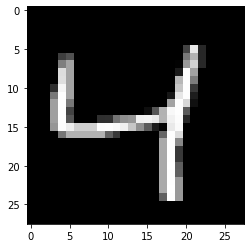

In [70]:
from matplotlib import pyplot as plt

# On met le type des images en float.
X0 = X0.astype('float32')
X1 = X1.astype('float32')
# On met les images sous la forme de vecteur.
X0 = X0.reshape(60000, 784)
X1 = X1.reshape(10000, 784) 
# On normalise les images.
X0 /= 255
X1 /= 255
n = 2
plt.imshow(X0[n, :].reshape(28, 28), cmap="gray")

## 2. Régression multinomiale.

La régression multinomiale est un modèle de classification qui étend la régression logistique lorsque le nombre de classes possibles est supérieur à 2. Le modèle est le suivant. On décrit la classe d'un individu au moyen d'une variable aléatoire $Y$ à valeurs dans un ensemble discret $\{1,\cdots, K\}$ représentant des étiquettes de classe. Pour chaque individu, on dispose de variables $x$ (dites de régression) dans $\mathbb{R}^p$. On suppose que la distribution de probabilités de $Y$ dépend de $x$ et d'un ensemble $\theta = (\theta^{(k)})_{k=1}^K$ de $K$ vecteurs de paramètres inconnus $\theta^{(k)}$ dans $\mathbb{R}^{p+1}$ selon le modèle **"soft-max"**
\begin{equation} \label{eqn:softmax_proba}
  \forall \: k \in \{1,\cdots, K\}, \: \mathbb{P}(Y = k) = \frac{\exp(\langle \theta^{(k)}, \:  \tilde{x} \rangle )}{\sum_{m=1}^K \exp(\langle \theta^{(m)},  \: \tilde{x} \rangle )},\:\:\mathrm{avec}\:\: \tilde{x} =  \left( \begin{array}{c} 1 \\ x \end{array} \right). \end{equation}

Les estimateurs du maximum de vraisemblance de l'échantillon sont les paramètres $\theta$ qui minimisent le **critère d'entropie croisée**:
    \begin{equation} \label{eqn:entropiecroisee}
       \mathcal{S}(\theta) = - \frac{1}{n} \sum_{i=1}^n \sum_{k=1}^K z_i^{(k)} \log\left(p_i^{(k)}(\theta) \right),\end{equation}
    avec
    \begin{equation} 
    z_i^{(k)} =  \mathbf{1}_{y_i = k}\:\:\:\mathrm{et}\:\:\: p_i^{(k)}(\theta) = \frac{\exp(\langle \theta^{(k)},  \: \tilde{x}_i \rangle )}{\sum_{m=1}^K \exp(\langle \theta^{(m)},  \: \tilde{x}_i \rangle )}. 
    \end{equation}   

 

Dans le cadre de ce TP, l'objectif est de classer les images MNIST en K=10 classes $\{0, \cdots, 9\}$. La variable $x_i$ représente la ième image (sous forme vectorielle) de la base d'apprentissage et $y_i$ son étiquette de classe.


## 3. Descente de gradient.

Une descente de gradient est un algorithme itératif permettant de minimiser une application différentiable $\mathcal{S}$ par rapport à un ensemble de variables $\theta$. Dans la descente de gradient à pas fixe, la mise à jour des variables $\theta$ s'écrit à chaque itération
\begin{equation} \label{eqn:miseajour}
  \theta \longleftarrow \theta - \rho \: \nabla_{\theta}  \mathcal{S}(\theta),
  \end{equation}
o\`u $\rho>0$ désigne un pas fixe et $\nabla_{\theta} \mathcal{S}$ le gradient de $\mathcal{S}$ par rapport à $\theta$. 


\exo  Le gradient de l'entropie croisée $\mathcal{S}$ par rapport à $\theta^{(k)}$ en $\theta$ vaut
    $$ \nabla_{\theta^{(k)}} \mathcal{S}(\theta) = \frac{1}{n} \sum_{i=1}^{n} \left(p_i^{(k)}(\theta) - z_i^{(k)}\right) \tilde{x}_i . $$


**Exercice 1.** Écrire une fonction Python qui calcule ce gradient en respectant le modèle suivant.

In [71]:
def Soft_Max(X, Theta):
    """
    Modèle soft-max de distribution de probabilité.        

    Parameters
    ----------
    X : ndarray (n x p).
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation. 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe.
        La colonne k contient les paramètres de régression 
        pour la classe k.

    Returns
    -------
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités
        des classes de toutes les observations.
        Sur la ligne i et la colonne k, P[i, k] donne l'estimation de 
        la probabilité que la ième observation soit dans la classe k
        selon le modèle soft-max.
    """   
    # Transformations linéaires et exponentielles.
    P = np.exp(np.dot(X, Theta[1:, :]) + Theta[0, :])
    # Normalisation.
    P = P / np.sum(P, axis=1).reshape(P.shape[0], 1)

    return(P)

def Cross_Entropy(C, P):
    """
    Critère d'entropie croisée.

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités des classes de toutes les observations
        (voir Soft_Max).
   
    Returns
    -------
    J : scalar.
        Valeur de l'entropie croisée.
    """ 
    V = np.zeros(C.shape)
    for i in range(V.shape[0]):
        V[i] = np.log(P[i, C[i]])
    
    return(-np.mean(V, axis=None))

In [72]:
def Gradient(C,P,X, Theta):
    """
    Gradient de l'entropie croisée 
    
    Paramètres 
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    P : ndarray (n x K)
        Matrice contenant les estimations des distributions
        de probabilités des classes de toutes les observations
        (voir Soft_Max).
    X : ndarray (n x p).
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation. 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe.
        La colonne k contient les paramètres de régression 
        pour la classe k.
    
    Returns
    -------
    G : ndarray (p+1 x K). 
    """
    X = np.c_[np.ones(X.shape[0]),X]  #Ajoute le vecteur 1 à la matrice de desing 
    n = X.shape[0]  #Nombre de paramètre 
    G = np.zeros(Theta.shape)  #Matrice contenant après les gradients des différents paramètres 
    for k in range(P.shape[1]) :  #Pour chaque paramètre associé à une classe 
        z = [0 if np.where(P[i] == P[i,:].max())[0][0] != C[i] else 1 for i in range(n) ]  #Vecteur indicateur 
        G[:,k] = np.sum(1/n*X.T*(P[:,k]-z), axis=1)  #Gradient de tous les paramètres de cette classe 
    return G 

**Exercice 2.** Appliquer l'algorithme de descente de gradient sur les données MNIST en prenant 50000 données d'apprentissage et 10000 de validation. A chaque époque (itération), calculer la valeur de l'entropie sur les données d'apprentissage et de validations, ainsi que les scores de classification sur ces deux jeux de données. Relever également le temps d'exécution de chaque époque. Tracer ensuite les valeurs d'entropie et les scores de classification en fonction du temps de calcul (et/ou de l'époque). Pour le calcul du score de classification, on pourra s'aider de la fonction suivante.

In [73]:
def Classification_Score(C, X, Theta):
    """
    Score de classification obtenu par régression multinomiale.

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    P = Soft_Max(X, Theta)
    Cest = np.argmax(P, axis=1)
    score = np.nonzero(Cest == C)[0].size / P.shape[0] * 100
    
    return(score, P)

In [74]:
#Création de données de validation 

X_train = X0[:50000]
X_test = X0[50000:]

y_train = Y0[:50000]
y_test = Y0[50000:]

#Jeu de données train et test

#X_train = X0
#X_test = X1

#y_train = Y0
#y_test = Y1

iteration = 20

In [75]:
#Theta = np.random.randint(10, size=(X0.shape[1]+1, 10))
random.seed(10)
Theta = np.random.rand(X0.shape[1]+1, 10)

In [76]:
def DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration, rho=1e-2) :
    
    """
    Algorithme de descente de gradient 

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Y : ndarray (n x 1)
        Vecteur contenant les classes de chaque exemple 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.
    Iteration : réel 
        Nombre de fois où le modèle est entrainé sur le jeu de données 
    rho : nombre décimal 
        pas fixe 

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    
    Entropie_Train = [] #liste qui contiendra le loss
    score_train = []  
    
    Entropie_Test = []
    score_test = []
    
    Theta = Theta.astype('float64')
    
    for i in range(iteration) : 
        
        start_time = time.time()
        
        P_train =  Soft_Max(X_train, Theta)  #Proba de chaque classe pour le train 
        P_test = Soft_Max(X_test, Theta)
        
        Entropie_Train.append(Cross_Entropy(y_train,P_train))  #Erreur train
        Entropie_Test.append(Cross_Entropy(y_test, P_test))  #Erreur test 
        
        score_train.append(Classification_Score(y_train, X_train, Theta)[0])  #Score train 
        score_test.append(Classification_Score(y_test, X_test, Theta)[0])  #Score test
    
        G = Gradient(y_train,P_train,X_train, Theta)
        
        Theta -= rho*G  #Mise à jour du gradient 
        
        print("--- %s seconds ---" % (time.time() - start_time))
        
    return(Entropie_Train,Entropie_Test,score_train,score_test, Theta)
        
        

In [77]:
(Entropie_Train,Entropie_Test,score_train,score_test, Theta_DG) = DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration)

--- 8.74510908126831 seconds ---
--- 8.390963315963745 seconds ---
--- 7.6527769565582275 seconds ---
--- 7.53608512878418 seconds ---
--- 7.560003042221069 seconds ---
--- 7.4124369621276855 seconds ---
--- 7.421588897705078 seconds ---
--- 7.402545928955078 seconds ---
--- 7.445439100265503 seconds ---
--- 7.387683868408203 seconds ---
--- 7.449540138244629 seconds ---
--- 7.446968078613281 seconds ---
--- 7.581496000289917 seconds ---
--- 7.545357942581177 seconds ---
--- 7.976664066314697 seconds ---
--- 7.40339994430542 seconds ---
--- 7.581864833831787 seconds ---
--- 7.297775745391846 seconds ---
--- 7.376529932022095 seconds ---
--- 7.376080751419067 seconds ---


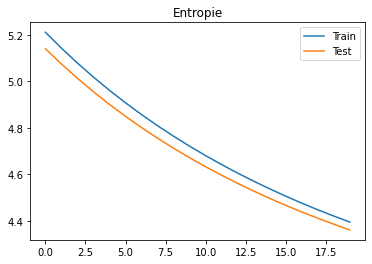

In [78]:
x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.show()

Les deux courbes décroissent à la même vitesse, ce qui est un marqueur d'un bon fonctionnement de l'agorithme. En effet, nous observons ni over ou under fitting. 

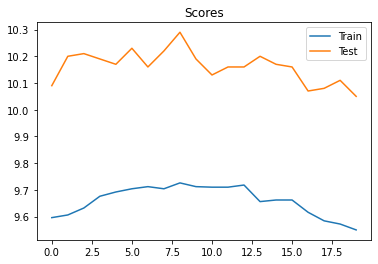

In [79]:
x = np.array([i for i in range(iteration)])
y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.show()

---
Les scores plafonent à 10, ce qui n'est pas incoryable .. La régression logistique appliquée comme ici ne prend pas en compte l'emplacement des informations de l'image. Cette dernière est traité comme un ensemble lisse de données, or l'emplacement des informaitons est importante ! Nous pouvons regarder plus précisément ce que notre modèle prédit. 

---

**Fonction de prédition**

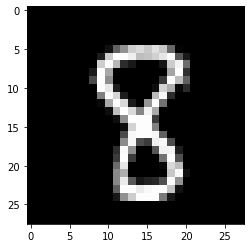

In [210]:
plt.imshow(X_test[1, :].reshape(28, 28), cmap="gray")

In [211]:
def prediction(X, Theta) : 
    P = Soft_Max(X, Theta)
    #print(P[0])
    pred = []
    for i in P : 
        pred.append(np.argmax(i))
    return pred

In [212]:
y_pred = prediction(X_test, Theta_DG)

In [213]:
y_pred[1]

9

## 4. Descente de gradient stochastique par mini-lots.

L'algorithme de gradient stochastique est une modification de l'algorithme du gradient qui consiste à prendre un seul exemple d'apprentissage au hasard pour mettre à jour le paramètre $\theta$ à chaque époque. On s'intéresse ici à une variante de l'algorithme de gradient stochastique qui fait ces mises à jour en prenant une série de mini-lots (batchs) d'exemples d'apprentissage tiré au hasard. Pour cet algorithme, le gradient de l'entropie croisée $\mathcal{S}$ s'écrira
$$ \nabla_{\theta^{(k)}} \mathcal{S}(\theta) = \frac{1}{m} \sum_{i \in B_j} \left(p_i^{(k)}(\theta) - z_i^{(k)}\right) \tilde{x}_i, $$
o\`u $B_j$ est un ensemble qui regroupe $m$ indices d'un jème lot d'observations pris au hasard. Une époque de l'algorithme consistera en une série de plusieurs mises à jour faisant intervenir différents lots. Le nombre de mises à jour pour une époque pourra par exemple être fixé à $\lfloor n / m \rfloor$. La descente de gradient ordinaire est un cas particulier de la descente de gradient stochastique lorsque l'on fixe $m=n$. 

**Exercice 3.** Modifier le programme de la section précédente pour inclure des mises à jour sur mini-lots. Appliquer le programme aux données MNIST. Comparer les convergences des algorithmes de gradient et gradient stochastique par mini-lots. Discuter.



In [85]:
def DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=1,rho=1e-2) :
    
    """
    Algorithme de descente de gradient 

    Parameters
    ----------
    C : ndarray (n x 1)
        Vecteur contenant les étiquettes de classe de chaque
        observation.
    X : ndarray (n x p)
        Matrice contenant les variables de régression.
        La ligne i contient les valeurs des variables de régression 
        pour la ie observation.
    Y : ndarray (n x 1)
        Vecteur contenant les classes de chaque exemple 
    Theta : ndarray (p+1 x K).
        Matrice contenant les paramètres de régression pour 
        chaque classe. La colonne k contient les paramètres
        de régression pour la classe k.
    Iteration : réel 
        Nombre de fois où le modèle est entrainé sur le jeu de données 
    rho : nombre décimal 
        pas fixe 
    batch : réel 
        Nombre de mini-lots

    Returns
    -------
    score : scalar
        Pourcentage d'observations bien classées.
    P : ndarray (n, K)
        Probabilités d'appartenance aux classes de chaque observation.
    """
    
    Entropie_Train = []
    score_train = []
    
    Entropie_Test = []
    score_test = []
    
    Theta = Theta.astype('float64')
    
    pas = X_train.shape[0] // batch  #Division en mini lot 
    
    for i in range(iteration) :  #Pour chaque itération 
        
        ind = 0
        
        for b in range(batch) :  #Pour chaque mini-lot 
        
            start_time = time.time()

            P_train =  Soft_Max(X_train[ind:ind+pas], Theta)          

            G = Gradient(y_train[ind:ind+pas],P_train,X_train[ind:ind+pas], Theta)

            Theta -= rho*G
            
            ind += pas 
            
            print("--- %s seconds ---" % (time.time() - start_time))
            
        P_train =  Soft_Max(X_train, Theta)
        P_test = Soft_Max(X_test, Theta)
        
        Entropie_Train.append(Cross_Entropy(y_train,P_train))
        Entropie_Test.append(Cross_Entropy(y_test, P_test))
        
        score_train.append(Classification_Score(y_train, X_train, Theta)[0])
        score_test.append(Classification_Score(y_test, X_test, Theta)[0])
        
    return(Entropie_Train,Entropie_Test,score_train,score_test)

In [86]:
random.seed(10)
Theta = np.random.rand(X0.shape[1]+1, 10)

In [87]:
(Entropie_Train,Entropie_Test,score_train,score_test) = DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=10)

--- 0.4993271827697754 seconds ---
--- 0.5005753040313721 seconds ---
--- 0.5054230690002441 seconds ---
--- 0.49059128761291504 seconds ---
--- 0.4940180778503418 seconds ---
--- 0.4969649314880371 seconds ---
--- 0.48940205574035645 seconds ---
--- 0.5000147819519043 seconds ---
--- 0.49350404739379883 seconds ---
--- 0.48565196990966797 seconds ---
--- 0.4960319995880127 seconds ---
--- 0.6036639213562012 seconds ---
--- 0.6112940311431885 seconds ---
--- 0.6123497486114502 seconds ---
--- 0.6136689186096191 seconds ---
--- 0.582550048828125 seconds ---
--- 0.630202054977417 seconds ---
--- 0.4986560344696045 seconds ---
--- 0.6213870048522949 seconds ---
--- 0.5666990280151367 seconds ---
--- 0.48432302474975586 seconds ---
--- 0.4938507080078125 seconds ---
--- 0.4831380844116211 seconds ---
--- 0.5029017925262451 seconds ---
--- 0.4882469177246094 seconds ---
--- 0.5878040790557861 seconds ---
--- 0.492600679397583 seconds ---
--- 0.5082778930664062 seconds ---
--- 0.494649171829

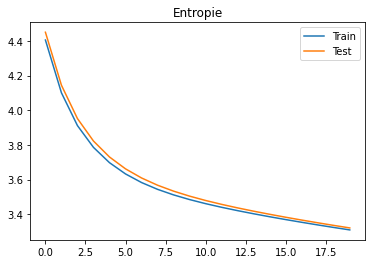

In [88]:
x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.show()

Ce graphique nous montre ni under ni over fitting. 

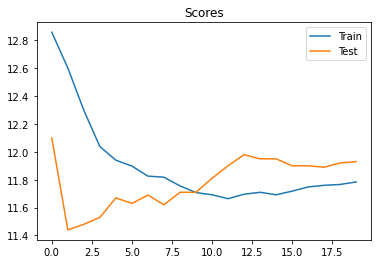

In [89]:
x = np.array([i for i in range(iteration)])
y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.show()

---
Ici nous pouvons constater que les courbes sont encore très basses le modèle sous apprend toujours. 

---

**Exercice 4.** On réduit le nombre d'exemples d'apprentissage à 1000. Comparer et discuter les convergences des algorithmes appliqués dans ce cas et dans celui o\`u le nombre d'exemple est fixé à 50000.



In [90]:
X_train = X0[:1000]
y_train = Y0[:1000]

In [91]:
#random.seed(10)
#Theta = np.random.rand(X_train.shape[1]+1, 10)

In [92]:
(Entropie_Train,Entropie_Test,score_train,score_test, Theta_DG) = DescentGradient(X_train,X_test, y_train, y_test, Theta, iteration)
(Entropie_Train_St,Entropie_Test_St,score_train_St,score_test_St) = DescentGradientStochastique(X_train,X_test, y_train, y_test, Theta, iteration, batch=10)

--- 0.20257806777954102 seconds ---
--- 0.16872715950012207 seconds ---
--- 0.19095206260681152 seconds ---
--- 0.16723084449768066 seconds ---
--- 0.1850886344909668 seconds ---
--- 0.16458988189697266 seconds ---
--- 0.1766672134399414 seconds ---
--- 0.17423295974731445 seconds ---
--- 0.17209982872009277 seconds ---
--- 0.16817212104797363 seconds ---
--- 0.17767024040222168 seconds ---
--- 0.16666007041931152 seconds ---
--- 0.1781597137451172 seconds ---
--- 0.17509078979492188 seconds ---
--- 0.20590901374816895 seconds ---
--- 0.16993999481201172 seconds ---
--- 0.1928720474243164 seconds ---
--- 0.23728609085083008 seconds ---
--- 0.19723105430603027 seconds ---
--- 0.19350004196166992 seconds ---
--- 0.010001897811889648 seconds ---
--- 0.008753299713134766 seconds ---
--- 0.008959054946899414 seconds ---
--- 0.008858919143676758 seconds ---
--- 0.008467912673950195 seconds ---
--- 0.00845789909362793 seconds ---
--- 0.008583307266235352 seconds ---
--- 0.00855565071105957 se

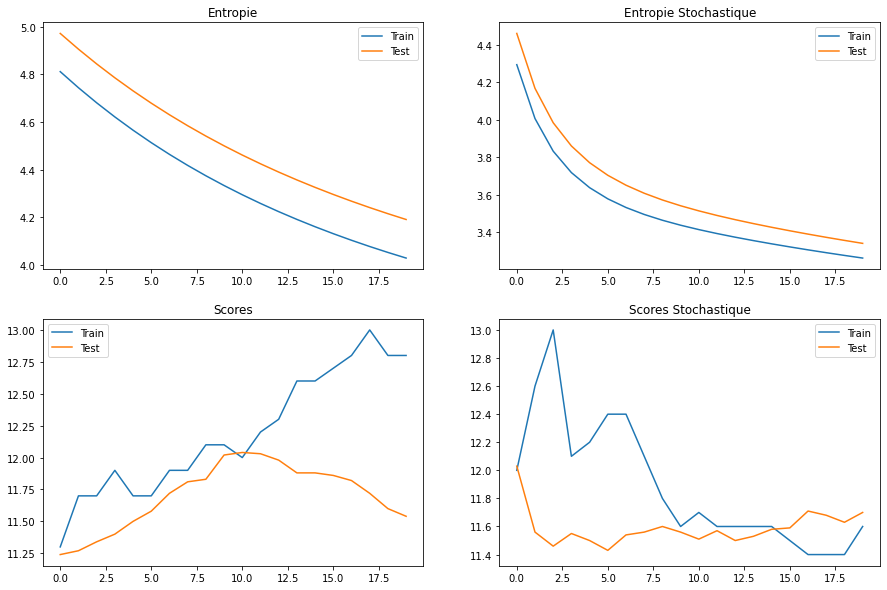

In [93]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(Entropie_Train)
w = np.array(Entropie_Test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie")

plt.subplot(222)

y = np.array(Entropie_Train_St)
w = np.array(Entropie_Test_St)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Entropie Stochastique")

plt.subplot(223)

y = np.array(score_train)
w = np.array(score_test)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores")

plt.subplot(224)

y = np.array(score_train_St)
w = np.array(score_test_St)
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Scores Stochastique")



plt.show()


---
On peut observer que la fonction de perte diminue plus rapidement dans le cas d'un gradient stochastique (mini-batch) avec peu de données. En revanche, les scores sont comparables entre eux. De plus, les scores sont comparables à ceux obtenus avec 6 fois plus de données. Cela prouve qu'un nombre plus important de données n'infuence pas la performance de l'algoritme mais bien son efficacité en terme de vitesse. 

---

## 6. Régression multinomiale en keras.

**Exercice 5.** Mettre en oeuvre en keras le modèle de régression multinomiale. L'appliquer aux données MNIST. Tracer et commenter l'historique de l'apprentissage.


In [26]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [27]:
num_classes = 10
input_shape = (784,1)

In [28]:
y_train = keras.utils.to_categorical(Y0, num_classes) #Le vecteur labels est transformé en matrice (n x k) 
#où y_nk = 1 quand y_n = k, 0 sinon 
y_test = keras.utils.to_categorical(Y1, num_classes)

In [29]:
y_train.shape

(60000, 10)

In [30]:
model = keras.Sequential(
    [
        keras.Input(shape=(784,1)), #shape de chaque vecteur d'entrée 
        layers.Flatten(), # Applatissement de la matrice (784 x 10) 
        layers.Dense(num_classes, activation="softmax"), #Couche dense applicant la fonction d'acitivation softmax
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"]) #  Fonction de perte cossentropy et score 


In [32]:
history = model.fit(X0, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 2s 969us/step - loss: 0.7393 - accuracy: 0.8037 - val_loss: 0.3072 - val_accuracy: 0.9123
Epoch 2/20
1500/1500 [==============================] - 1s 611us/step - loss: 0.3189 - accuracy: 0.9090 - val_loss: 0.2828 - val_accuracy: 0.9227
Epoch 3/20
1500/1500 [==============================] - 1s 612us/step - loss: 0.2955 - accuracy: 0.9162 - val_loss: 0.2794 - val_accuracy: 0.9243
Epoch 4/20
1500/1500 [==============================] - 1s 607us/step - loss: 0.2854 - accuracy: 0.9228 - val_loss: 0.2785 - val_accuracy: 0.9237
Epoch 5/20
1500/1500 [==============================] - 1s 611us/step - loss: 0.2835 - accuracy: 0.9225 - val_loss: 0.2780 - val_accuracy: 0.9256
Epoch 6/20
1500/1500 [==============================] - 1s 610us/step - loss: 0.2769 - accuracy: 0.9255 - val_loss: 0.2744 - val_accuracy: 0.9278
Epoch 7/20
1500/1500 [==============================] - 1s 606us/step - loss: 0.2734 - accuracy: 0.9261 - val_loss: 0.2756 -

In [33]:
score = model.evaluate(X1, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.30853426456451416
Test accuracy: 0.9264000058174133


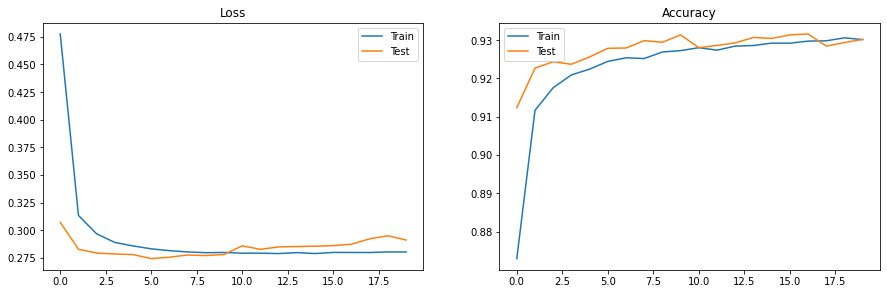

In [34]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Ici on observe un bon entrainement sur les données. Ici le classifieur est entrainé sur 6000 données où 1200 sevent de cross validation. Il est tout de même testé à chaque tour sur 1000 données séparées. Malgrès que le jeu de données ne soit pas équivalent à celui précédent (5000<6000), le score est si différent que de modifier cela ne ferait pas de différence. 

La fonction de perte commence à augmenter à partir de 10 epochs, cela nous renseigne sur le moment où nous aurions pu arrêter l'entrainement. 

---

**Exercice 6.** Mettre en oeuvre en Keras le réseau de neurones convolutionnel inspiré de LeNet-5 dont les couches sont décrites dans le tableau ci-dessous:

| Type | Cartes | Noyau | Pas | Activation |
|------|--------|-------|-----|-------|
| Conv.| 6      | 5x5   | 1   | tanh  |
| Av. Pooling | 6 | 2x2 | 2 | - | 
|Conv. | 12 | 5x5 | 1 | tanh |
| Av. Pooling | 12 | 2x2 | 4 | - | 
| Dense | - | 10 | - | softmax|

1. Indiquer la dimension des images et le nombre de paramètres à chaque couche. Comparer avec le modèle dense de la régression multinomiale.

2. Appliquer le modèle aux données MNIST. Comparer les résultats avec ceux de la régression multinomiale.

3. Visualiser les noyaux de convolution et apporter quelques éléments d'interprétation.

4. Faire l'apprentissage du réseau sur 6000 exemples. Comparer ses performances avec le réseau dense appris dans les mêmes conditions. Discuter.



### Vecteur

In [35]:
keras.backend.clear_session()

In [36]:
x_train = np.expand_dims(X0, -1)
x_test = np.expand_dims(X1, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 784, 1)
60000 train samples
10000 test samples


In [37]:
iteration = 20
input_shape = (784, 1)
num_classes = 10

In [38]:
y_train = keras.utils.to_categorical(Y0, num_classes)
y_test = keras.utils.to_categorical(Y1, num_classes)

In [39]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape), 
        keras.layers.Conv1D(filters=6, kernel_size=5, strides=1, activation="tanh"),
        keras.layers.AveragePooling1D(2*2, strides=2),
        keras.layers.Conv1D(filters=12, kernel_size=5, strides=1, activation="tanh"),
        keras.layers.AveragePooling1D(2*2, strides=4),
        keras.layers.Flatten(),
        keras.layers.Dense(units=num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 780, 6)            36        
_________________________________________________________________
average_pooling1d (AveragePo (None, 389, 6)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 385, 12)           372       
_________________________________________________________________
average_pooling1d_1 (Average (None, 96, 12)            0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                11530     
Total params: 11,938
Trainable params: 11,938
Non-trainable params: 0
____________________________________________________

In [40]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.6583 - accuracy: 0.8161 - val_loss: 0.2474 - val_accuracy: 0.9273
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2610 - accuracy: 0.9211 - val_loss: 0.2060 - val_accuracy: 0.9405
Epoch 3/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.2140 - accuracy: 0.9366 - val_loss: 0.1790 - val_accuracy: 0.9484
Epoch 4/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1811 - accuracy: 0.9454 - val_loss: 0.1739 - val_accuracy: 0.9511
Epoch 5/20
1500/1500 [==============================] - 10s 7ms/step - loss: 0.1704 - accuracy: 0.9484 - val_loss: 0.1654 - val_accuracy: 0.9528
Epoch 6/20
1500/1500 [==============================] - 10s 6ms/step - loss: 0.1591 - accuracy: 0.9516 - val_loss: 0.1623 - val_accuracy: 0.9522
Epoch 7/20
1500/1500 [==============================] - 9s 6ms/step - loss: 0.1536 - accuracy: 0.9526 - val_loss: 0.1637 - val_accurac

In [41]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.1254134476184845
Test accuracy: 0.9614999890327454


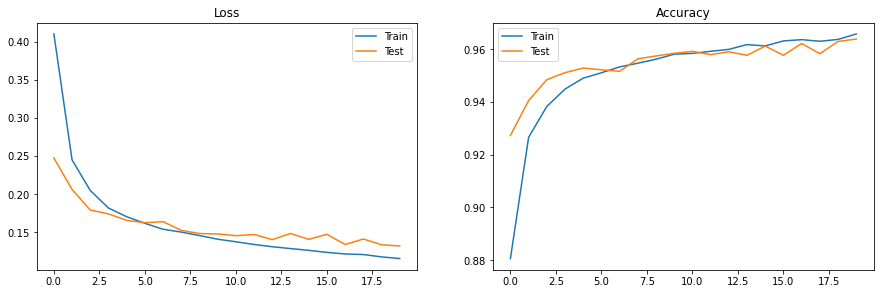

In [42]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Ici le modèle en 1D est assez efficace mais les courbes varient ce qui évoque une instabilité de l'apprentissage. En effet, les images étant en 2D, l'apprentissage en 1D n'est pas naturelle. L'information spatiale est perdue. 

---

### Matrice

In [238]:
keras.backend.clear_session()

In [239]:
X0 = X0.reshape(60000, 28, 28)
X1 = X1.reshape(10000, 28, 28)
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(X0, -1)
x_test = np.expand_dims(X1, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [240]:
iteration = 20
num_classes = 10

In [241]:
y_train = keras.utils.to_categorical(Y0, num_classes)
y_test = keras.utils.to_categorical(Y1, num_classes)

In [242]:
input_shape = (28, 28,1)
num_classes = 10

In [48]:
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(2*2, strides=2),
        keras.layers.Conv2D(filters=12, kernel_size=(5, 5), strides=1, activation="tanh"),
        keras.layers.AveragePooling2D(),
        keras.layers.Flatten(),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 11, 11, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 12)          1812      
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 108)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1090      
Total params: 3,058
Trainable params: 3,058
Non-trainable params: 0
______________________________________________________

In [49]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 9s 5ms/step - loss: 0.8381 - accuracy: 0.7717 - val_loss: 0.2472 - val_accuracy: 0.9287
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2315 - accuracy: 0.9321 - val_loss: 0.1611 - val_accuracy: 0.9524
Epoch 3/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1496 - accuracy: 0.9554 - val_loss: 0.1145 - val_accuracy: 0.9669
Epoch 4/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1177 - accuracy: 0.9656 - val_loss: 0.0966 - val_accuracy: 0.9717
Epoch 5/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0934 - accuracy: 0.9734 - val_loss: 0.0863 - val_accuracy: 0.9757
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0834 - accuracy: 0.9760 - val_loss: 0.0754 - val_accuracy: 0.9784
Epoch 7/20
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0743 - accuracy: 0.9776 - val_loss: 0.0764 - val_accuracy:

In [50]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.040535926818847656
Test accuracy: 0.9871000051498413


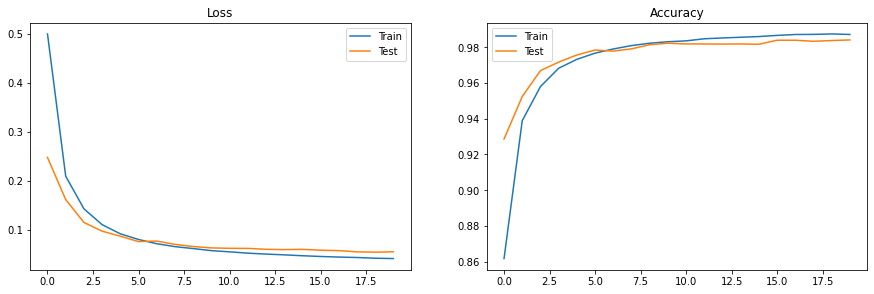

In [51]:
plt.figure(figsize = (15, 10))

plt.subplot(221)

x = np.array([i for i in range(iteration)])
y = np.array(history.history['loss'])
w = np.array(history.history['val_loss'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Loss")

plt.subplot(222)

y = np.array(history.history['accuracy'])
w = np.array(history.history['val_accuracy'])
plt.plot(x, y, label='Train')
plt.plot(x, w, label='Test')
plt.legend()
plt.title("Accuracy")

plt.show()

--- 
Nous pouvons observer que les résultats du mdèles en 2D est meilleur qu'en une seule dimension. Nous puvons aussi voir que l'entrainement pourrait s'arreter au bout de 5 epochs. 

---

### Visualisation des couches 

In [243]:
keras.backend.clear_session()

In [244]:
model = keras.Sequential()
model.add(keras.Input(shape=input_shape))
model.add(keras.layers.Conv2D(filters=6, kernel_size=(5, 5), strides=1, activation="tanh"))
model.add(keras.layers.AveragePooling2D(2*2, strides=2))
model.add(keras.layers.Conv2D(filters=12, kernel_size=(5, 5), strides=1, activation="tanh"))
model.add(keras.layers.AveragePooling2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(num_classes, activation="softmax"))


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 11, 11, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 12)          1812      
_________________________________________________________________
average_pooling2d_1 (Average (None, 3, 3, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 108)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                1090      
Total params: 3,058
Trainable params: 3,058
Non-trainable params: 0
______________________________________________________

In [245]:
model.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=iteration, validation_split=0.2)

Epoch 1/20
1500/1500 [==============================] - 9s 5ms/step - loss: 0.8457 - accuracy: 0.7595 - val_loss: 0.2071 - val_accuracy: 0.9424
Epoch 2/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1970 - accuracy: 0.9441 - val_loss: 0.1344 - val_accuracy: 0.9617
Epoch 3/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1309 - accuracy: 0.9626 - val_loss: 0.1080 - val_accuracy: 0.9689
Epoch 4/20
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1053 - accuracy: 0.9687 - val_loss: 0.0893 - val_accuracy: 0.9742
Epoch 5/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0867 - accuracy: 0.9730 - val_loss: 0.0851 - val_accuracy: 0.9765
Epoch 6/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0773 - accuracy: 0.9778 - val_loss: 0.0732 - val_accuracy: 0.9792
Epoch 7/20
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0724 - accuracy: 0.9786 - val_loss: 0.0717 - val_accuracy:

In [246]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.04113612323999405
Test accuracy: 0.9864000082015991


In [247]:
img_tensor = X1[1].reshape(28, 28)
print(img_tensor.shape)
img_tensor = image.img_to_array(img_tensor)
print(img_tensor.shape)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)
#plt.imshow(img_tensor)
#plt.show()
print(img_tensor.shape)

(28, 28)
(28, 28, 1)
(1, 28, 28, 1)
(1, 28, 28, 1)


In [248]:
layer_outputs = [layer.output for layer in model.layers[:7]] 
# Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) 
# Creates a model that will return these outputs, given the model input

In [249]:
activations = activation_model.predict(img_tensor) 
# Returns a list of five Numpy arrays: one array per layer activation

**Image d'entrée**

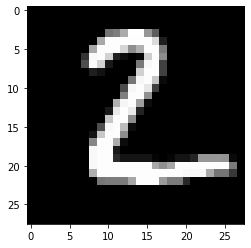

In [250]:
plt.imshow(X1[1, :].reshape(28, 28), cmap="gray")
plt.show()

**1ere couche de convolution** 

In [251]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 24, 24, 6)


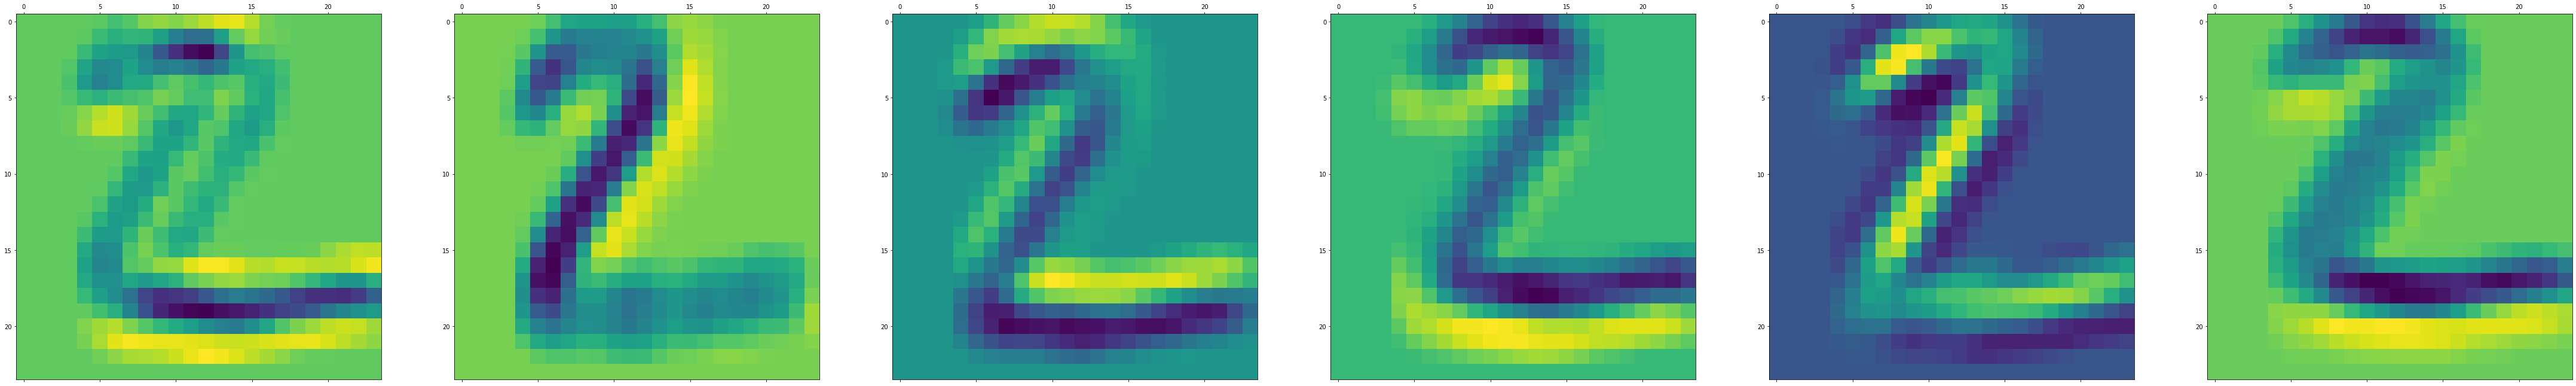

In [252]:
ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

**2eme couche**

In [253]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 11, 11, 6)


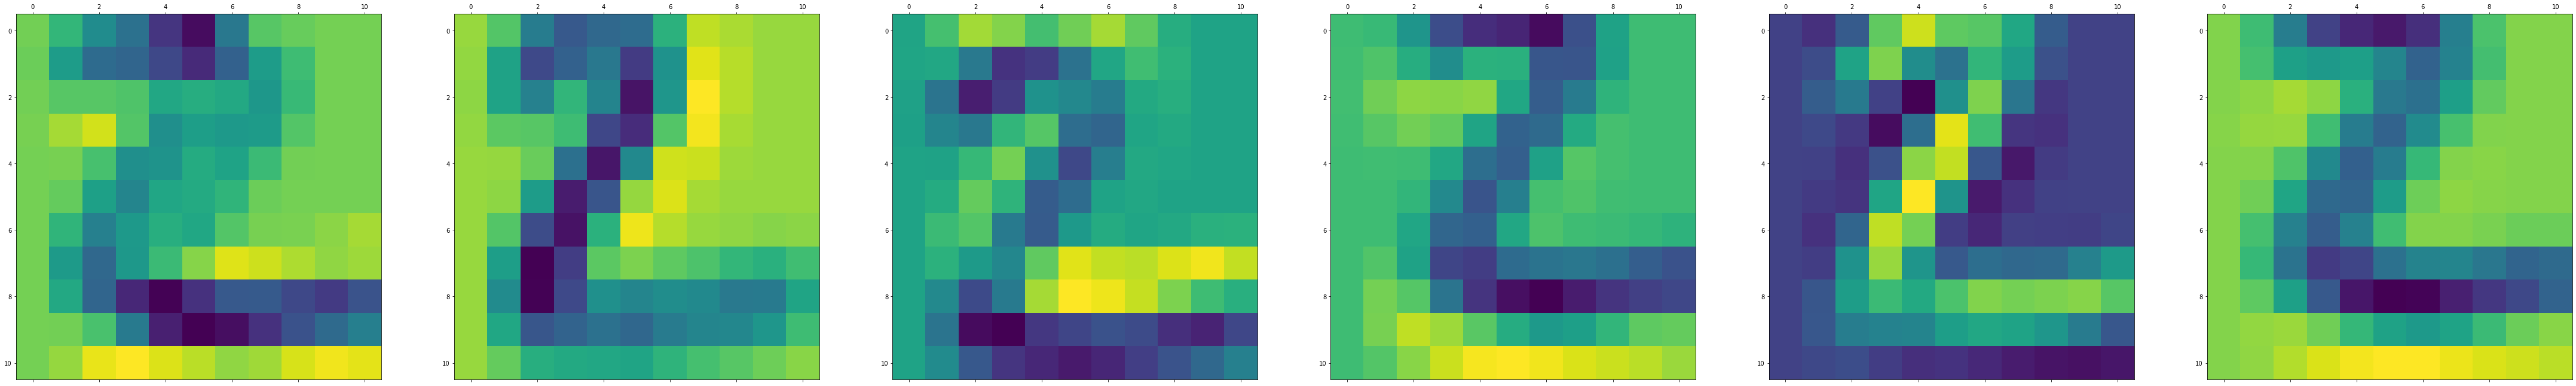

In [254]:
ncols = 6
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

**3eme couche**

In [255]:
first_layer_activation = activations[2]
print(first_layer_activation.shape)

(1, 7, 7, 12)


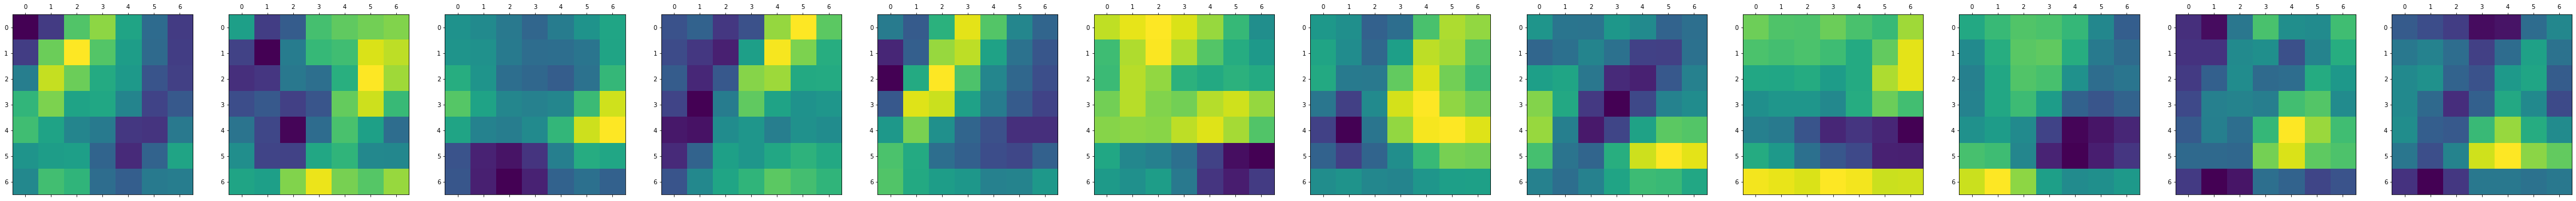

In [256]:
ncols = 12
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

**4eme couche**

In [257]:
first_layer_activation = activations[3]
print(first_layer_activation.shape)

(1, 3, 3, 12)


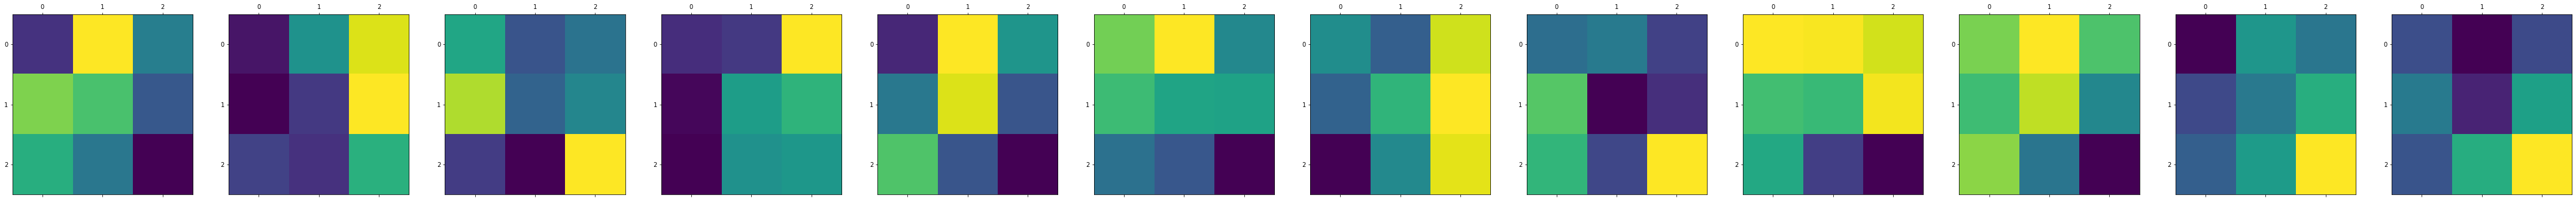

In [258]:
ncols = 12
nrows = 1
grid = GridSpec(nrows, ncols,left=0.1, bottom=0.05, right=10, top=10)
fig = plt.figure(0)
fig.clf()


ax = []
for i in range(ncols) : 
    ax.append(fig.add_subplot(grid[0, i]))
for i in range(ncols) : 
    ax[i].matshow(first_layer_activation[0, :, :, i], cmap='viridis')
    
plt.show()

Visualisation d'un réseau de neurones sur les données MNIST : https://www.cs.ryerson.ca/~aharley/vis/conv/